# Expanding Variable Cluster Timeline

Author: Sofia Ingersoll 

Date: 2024 May 5

## Increaseing Timeline
Loading files in 4, 500 cluster chunks 
`campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC0113.clm2.h0.1995-02-01-00000.nc`

In [32]:
import xarray as xr
import pickle
from utils import * 

In [2]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 30)
# apply peer2peer network communication across multiple devices
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.100:34277,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
def read_all_simulations2(var):
    '''Prepare cluster list and read to create ensemble(group of data)
    Use preprocess to select only certain dimension and a variable'''
    # Define the list of lists
    cluster_lists = [
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.1995-02-01-00000.nc'))[1:],
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2000-02-01-00000.nc'))[1:],
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2005-02-01-00000.nc'))[1:],
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2010-02-01-00000.nc'))[1:]
    ]
    
    def preprocess(ds, var):
        '''using this function in xr.open_mfdataset as preprocess
        ensures that when only these four things are selected 
        before the data is combined'''
        return ds[['lat', 'lon', 'time', var]]
    
    #read the list and load it for the notebook
    ds = xr.open_mfdataset( cluster_lists, 
                            combine='nested',
                           # lambda allows us to call the predefined preprocess on the ds
                            preprocess = lambda ds: preprocess(ds, var),
                            parallel= True, 
                            concat_dim= ["time", "ens"])
    return ds

In [4]:
# this ran and the outputs are closer to what we expect
# WE OFFICIALLY HAVE 1995 - 2015
ds = read_all_simulations2("LNC")

In [5]:
ds

<xarray.Dataset> Size: 192MB
Dimensions:  (lat: 96, lon: 144, time: 240, ens: 500, gridcell: 400)
Coordinates:
  * lat      (lat) float32 384B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 2kB 1995-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: ens, gridcell
Data variables:
    LNC      (ens, time, gridcell) float32 192MB dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 08/09/23 23:29:43
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_transient_LHC0001.clm...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

## Adding Time Selection!

To keep things simple, we are going to limit our users to the start date of 1995:

- 1995-2000 [only list 1 on back end]

- 1995-2005 [up to list 2 on back end] 

- 1995-2010 [up to list 3 on back end]

- 1995-2015 [up to list 4 on back end]


In [6]:
def read_all_simulations2(var, time_selection):
    '''Prepare cluster list and read to create ensemble(group of data)
    Use preprocess to select only certain dimension and a variable'''
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----  Define list of cluster lists ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    cluster_lists = [
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.1995-02-01-00000.nc'))[1:],
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2000-02-01-00000.nc'))[1:],
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2005-02-01-00000.nc'))[1:],
        sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2010-02-01-00000.nc'))[1:]
    ]

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----   If-else Load Selected Time  ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Select appropriate lists based on the time_selection
    
        # up to list 1
    if time_selection == '1995-2000':
        selected_lists = cluster_lists[:1]
         # up to list 2
    elif time_selection == '1995-2005':
        selected_lists = cluster_lists[:2]
         # up to list 3
    elif time_selection == '1995-2010':
        selected_lists = cluster_lists[:3]
         # up to list 4
    elif time_selection == '1995-2015':
        selected_lists = cluster_lists[:4]
    else:
        # to ensure a user selects time range
        raise ValueError("Uh oh, please select a time range that is currently available.")

    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----    Prepping to Load Cluster   ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    def preprocess(ds, var):
        '''using this function in xr.open_mfdataset as preprocess
        ensures that when only these four things are selected 
        before the data is combined'''
        return ds[['lat', 'lon', 'time', var]]

    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----      Load in Cluster Data     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # read the list and load it for the notebook
    ds = xr.open_mfdataset( selected_lists, 
                            combine='nested',
                           # lambda allows us to call the predefined preprocess on the ds
                            preprocess = lambda ds: preprocess(ds, var),
                            parallel= True, 
                            concat_dim= ["time", "ens"])

    # we aren't going to save these files because they need to be preprocessed 
    # using the wrangle and subset functions
    # better to keep these things broken up / shorter for future works updates
    # makes sense to keep if else pulling statement at the top of read_n_wrangle
    return ds

In [7]:
var = read_all_simulations2("LNC",'1995-2000')

In [8]:
# sweet, time: 60
var

<xarray.Dataset> Size: 48MB
Dimensions:  (lat: 96, lon: 144, time: 60, ens: 500, gridcell: 400)
Coordinates:
  * lat      (lat) float32 384B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 480B 1995-02-01 00:00:00 ... 2000-01-01 00:00:00
Dimensions without coordinates: ens, gridcell
Data variables:
    LNC      (ens, time, gridcell) float32 48MB dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 08/09/23 23:29:43
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_transient_LHC0001.clm...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

In [9]:
var2 = read_all_simulations2("LNC",'1995-2005')

In [10]:
# sweet, time: 120
var2

<xarray.Dataset> Size: 96MB
Dimensions:  (lat: 96, lon: 144, time: 120, ens: 500, gridcell: 400)
Coordinates:
  * lat      (lat) float32 384B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 960B 1995-02-01 00:00:00 ... 2005-01-01 00:00:00
Dimensions without coordinates: ens, gridcell
Data variables:
    LNC      (ens, time, gridcell) float32 96MB dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 08/09/23 23:29:43
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_transient_LHC0001.clm...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

In [11]:
var3 = read_all_simulations2("LNC",'1995-2010')

In [12]:
# sweet, time: 180
var3

<xarray.Dataset> Size: 144MB
Dimensions:  (lat: 96, lon: 144, time: 180, ens: 500, gridcell: 400)
Coordinates:
  * lat      (lat) float32 384B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 1kB 1995-02-01 00:00:00 ... 2010-01-01 00:00:00
Dimensions without coordinates: ens, gridcell
Data variables:
    LNC      (ens, time, gridcell) float32 144MB dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 08/09/23 23:29:43
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_transient_LHC0001.clm...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

In [13]:
var4 = read_all_simulations2("LNC",'1995-2015')

In [14]:
# sweet, time: 240!
# all timelines are pulling as expected!
var4

<xarray.Dataset> Size: 192MB
Dimensions:  (lat: 96, lon: 144, time: 240, ens: 500, gridcell: 400)
Coordinates:
  * lat      (lat) float32 384B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 2kB 1995-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: ens, gridcell
Data variables:
    LNC      (ens, time, gridcell) float32 192MB dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 08/09/23 23:29:43
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_transient_LHC0001.clm...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

### Testing Other Functions!

Let's add time selection to our workflow!

In [15]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# This is where 
# read_all_simulations appears in wkflw
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def subset_var_cluster2(var, time_selection):
    '''Subset the selected variable 
    (s) between 2005-2010 [for now, will be time range]
    as a xr.da.'''
    
    # Read in and wrangle user selected variable cluster
    da_v = read_all_simulations2(var, time_selection)
    # feb. ncar time bug
    da = fix_time(da_v)
    # convert xr.ds to xr.da
    da = da[var]

    return da.compute()

In [16]:
def read_n_wrangle2(param, var, time_selection):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----            Parameter Data.         ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # store user-inputs as global variables
    # will call later for plotting
    global param_name, var_name
    param_name = param
    var_name = var
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----            Parameter Data.         ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # pull in parameter data
    params = param_wrangling()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----        If-else Load Data     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    filepath = os.path.join("preprocessed_data", f"{var}_{time_selection}.nc")
    if os.path.exists(filepath):
         #read in the file as a dataset
        ds=xr.open_dataset('preprocessed_data/'+var+'_'+time_selection+'.nc')
    
        #then convert back to data array
        var_avg = ds[var]
    else:
        print(f"Reading and wrangling your data, this may take a few minutes")
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----    Subset User Selection Funct     ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    var_da = subset_var_cluster2(var, time_selection)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----      Subset Var Wrangle Funct      ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    var_avg = wrangle_var_cluster(var_da)

        # you ought to convert the data array to dataset before writing to file
    ds = var_avg.to_dataset(name = var)
    # note that this will throw error if you try to overwrite existing files
    ds.to_netcdf('preprocessed_data/'+var+'_'+time_selection+'.nc') 

    return params, var_avg, param_name, var_name

In [17]:
# this takes about 2 minutes to run
param_test, var_test, param_name, var_name = read_n_wrangle2("leafcn","LNC", time_selection = '1995-2015')

In [18]:
var_test.shape
var_test

<xarray.DataArray (ens: 500)> Size: 4kB
array([1.00483139, 0.94270426, 0.80605579, 1.1128554 , 0.80453896,
       0.89947509, 1.17311634, 1.07390253, 1.15246407, 0.95042113,
       0.92575337, 0.88109323, 0.80037626, 0.69054404, 0.91848529,
       0.65470052, 0.84413694, 0.74928195, 0.76841898, 1.00849537,
       1.03304884, 0.96510496, 0.64508573, 0.62692846, 0.8113084 ,
       0.89804134, 0.68622747, 0.99803847, 0.88498184, 0.84298645,
       0.5668954 , 0.7940038 , 0.90598016, 0.83229929, 0.99533558,
       0.71565572, 1.14975743, 0.92956121, 0.70375154, 0.58010059,
       1.4550065 , 0.88190826, 0.86925358, 0.80250983, 1.11572008,
       0.74331942, 1.28283612, 0.73988352, 0.75966279, 0.65763585,
       0.8046558 , 0.95892461, 0.88531088, 0.65444614, 0.97957942,
       0.7479346 , 0.71812983, 1.06881471, 0.90273297, 0.79920299,
       0.62173263, 0.98091734, 1.12732736, 1.33402347, 0.68673104,
       0.6494072 , 0.46486671, 1.07479399, 0.74369839, 0.69711758,
       0.79923297, 0.81781476, 0.79842728, 0.7160391 , 1.0134065 ,
       1.0762292 , 0.58411771, 0.97489135, 1.00316675, 0.8974827 ,
       0.9576883 , 0.70769551, 0.60089885, 0.775058  , 0.6856202 ,
       0.80232722, 1.00826583, 0.67553101, 0.61081382, 1.02827774,
       1.1391003 , 0.90146549, 1.22777658, 0.79298147, 0.68799567,
       0.95485484, 0.624383  , 0.92874903, 0.56012138, 0.73627882,
...
       0.5250748 , 0.91113726, 0.51218591, 0.90333593, 0.7186534 ,
       0.79830829, 0.85684721, 1.081304  , 1.09184664, 1.03069391,
       1.09396823, 1.03482179, 1.0899302 , 0.63589392, 0.99895348,
       1.08101282, 0.59851473, 0.95873581, 1.30624742, 0.68579923,
       0.73116038, 0.85341234, 0.89935879, 0.9106108 , 0.80627532,
       1.01398352, 0.72410183, 0.5902345 , 0.71129542, 0.6737649 ,
       0.9677413 , 0.85272023, 0.71096648, 0.87338698, 0.71629044,
       0.6119169 , 0.94932187, 0.60251337, 0.81745168, 0.87549494,
       0.75713172, 0.78749476, 0.86230202, 0.68574534, 0.55478205,
       0.98228629, 0.69014263, 0.56071103, 1.04437843, 0.84640924,
       0.93341076, 0.83494983, 1.08701967, 0.86300214, 0.66339375,
       0.51969231, 1.07132359, 0.58470903, 0.89186424, 0.67423432,
       0.93366672, 1.22330245, 0.79440031, 0.9491069 , 0.58697589,
       0.77379369, 0.65677785, 1.01295791, 0.55110768, 0.71357092,
       1.11226806, 0.90559835, 0.96262743, 0.99207887, 0.63474586,
       0.92134597, 0.72771233, 0.64391178, 0.89087412, 0.57595648,
       0.94136548, 0.53802087, 1.24665817, 1.00894514, 0.93981805,
       1.10759742, 0.94279827, 1.42957106, 0.65637618, 1.13095786,
       0.59948692, 0.965988  , 0.8184049 , 0.82870161, 0.67934924,
       0.74236659, 0.76305159, 0.96460325, 0.52084213, 0.96982045])
Dimensions without coordinates: ens

**The var dim post wrangling is ens.**

In [19]:
# this takes about 2 minutes to run
param_og, var_og, param_name_og, var_name_og = read_n_wrangle("leafcn","LNC")

In [20]:
var_og.shape
var_og

<xarray.DataArray 'LNC' (ens: 500)> Size: 4kB
[500 values with dtype=float64]
Dimensions without coordinates: ens

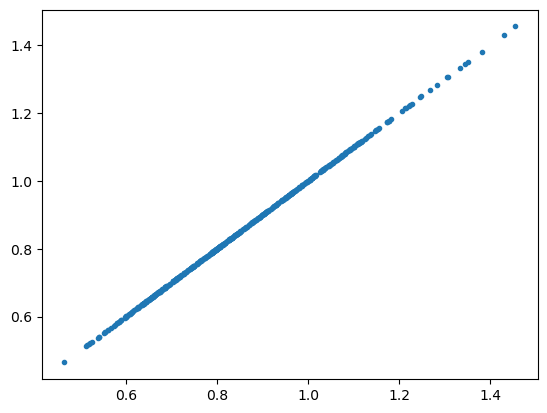

In [21]:
# wow! that's one straight line!
# we are looking good!
plt.plot(var_og,var_test,'.')

In [22]:
gpr_model, y_pred, y_std, y_test, X_test, r2_emulator = train_emulator(param_test, var_test)

Emulator is running, this may take a few moments
R^2: 0.9415520360334377
RMSE: 0.04752375585377918
Mean Absolute Error: 0.03799581460434838


### Expanding Emulator Capabilities
We want to iterate through all perturbed parameters to train the emulator

In [26]:
def create_parameter_names_dict():
    data = {
        key.upper(): value for key, value in {
            'FUN_fracfixers': 0, 'KCN': 1, 'a_fix': 2, 'crit_dayl': 3, 'd_max': 4, 'fff': 5,
            'froot_leaf': 6, 'fstor2tran': 7, 'grperc': 8, 'jmaxb0': 9, 'jmaxb1': 10, 'kcha': 11,
            'kmax': 12, 'krmax': 13, 'leaf_long': 14, 'leafcn': 15, 'lmr_intercept_atkin': 16,
            'lmrha': 17, 'lmrhd': 18, 'medlynintercept': 19, 'medlynslope': 20, 'nstem': 21,
            'psi50': 22, 'q10_mr': 23, 'slatop': 24, 'soilpsi_off': 25, 'stem_leaf': 26,
            'sucsat_sf': 27, 'theta_cj': 28, 'tpu25ratio': 29, 'tpuse_sf': 30, 'wc2wjb0': 31
        }.items()
    }
    return data
    
# object to store in utils outside of any function so it's callable
param_names_dict = create_parameter_names_dict()

In [ ]:
# to add at the top once its running right
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----   Load Pickled Emulation     ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#    filename = os.path.join("emulation_results", f"{var_name}_{param_names_dict[param_index]}_gpr_model.sav")

 #   if os.path.exists(filename):
        # Load the model from disk
  #      loaded_model = pickle.load(open(filename, 'rb'))
   # else:
    #    print(f"Emulator is running, this may take a few moments")
        
   

In [23]:
def train_emulator2(param, var, var_name, time_selection):
    # Split Data 90/10
    X_train, X_test, y_train, y_test = train_test_split(param, var, test_size=0.2, random_state=0)

    # Kernel Specs No Tuning
    kernel = ConstantKernel(constant_value=3, constant_value_bounds=(1e-2, 1e4)) * RBF(length_scale=1, length_scale_bounds=(1e-4, 1e8))

    # Using an out-of-the-box kernel for now
    gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, random_state=99, normalize_y=True)

    # Fit the model to the training data
    gpr_model.fit(X_train, y_train)

    # Prepare to store results
    results_dict = {
        'X_values': {},
        'y_pred': {},
        'y_std': {},
        'r2': {}
    }

    for param_name, param_index in param_names_dict.items():
        # Create X_values for prediction linspace
        X_values = np.full((100, len(param_names_dict)), 0.5)
        X_values[:, param_index] = np.linspace(0, 1, 100)

        # Make predictions for the current parameter
        y_pred, y_std = gpr_model.predict(X_values, return_std=True)

        # Collect Metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse_emulator = np.sqrt(mean_squared_error(y_test, y_pred))
        r2_emulator = np.corrcoef(y_test, y_pred)[0, 1]**2

        # Store results in dictionaries
        results_dict['X_values'][param_name] = X_values
        results_dict['y_pred'][param_name] = y_pred
        results_dict['y_std'][param_name] = y_std
        results_dict['r2'][param_name] = r2_emulator

        # Save the predictions and overall R^2 to a file
        filename = os.path.join("emulation_results", f"{var_name}_{param_name}_{time_selection}_gpr_model.sav")

        if os.path.exists(filename):
            # Load the model from disk
            loaded_model = pickle.load(open(filename, 'rb'))
        else:
            print(f"Emulator is running for {param_name}, this may take a few moments")
            with open(filename, 'wb') as file:
                pickle.dump((X_values, y_pred, y_std, r2_emulator, param_name, var_name), file)

    return results_dict

In [27]:
results_dict = train_emulator2(param_test, var_test, var_name, '1995-2015')

In [28]:
# Access the results for plotting
for param_name in param_names_dict.keys():
    X_values = results_dict['X_values'][param_name]
    y_pred = results_dict['y_pred'][param_name]
    y_std = results_dict['y_std'][param_name]
    r2_emulator = results_dict['r2'][param_name]
    # Plotting code can use the above values

In [29]:
# so this is performing a smidge better
# still no where near it's going to be for the dashboard
# need it back up to 0.94
# there's something funky happening when iterating
# already confirmed it'll load properly using the traditional emulator
r2_emulator

0.008192421945721725

### Plotting

In [ ]:
plot_emulator2(var_name, param_name, param_names_dict, '1995-2015')

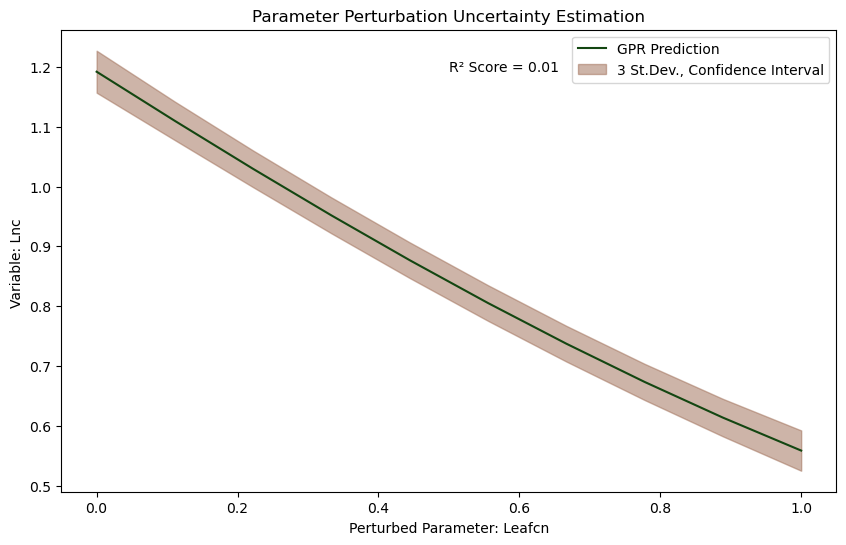

In [34]:
plot_emulator(gpr_model, y_test, r2_emulator)

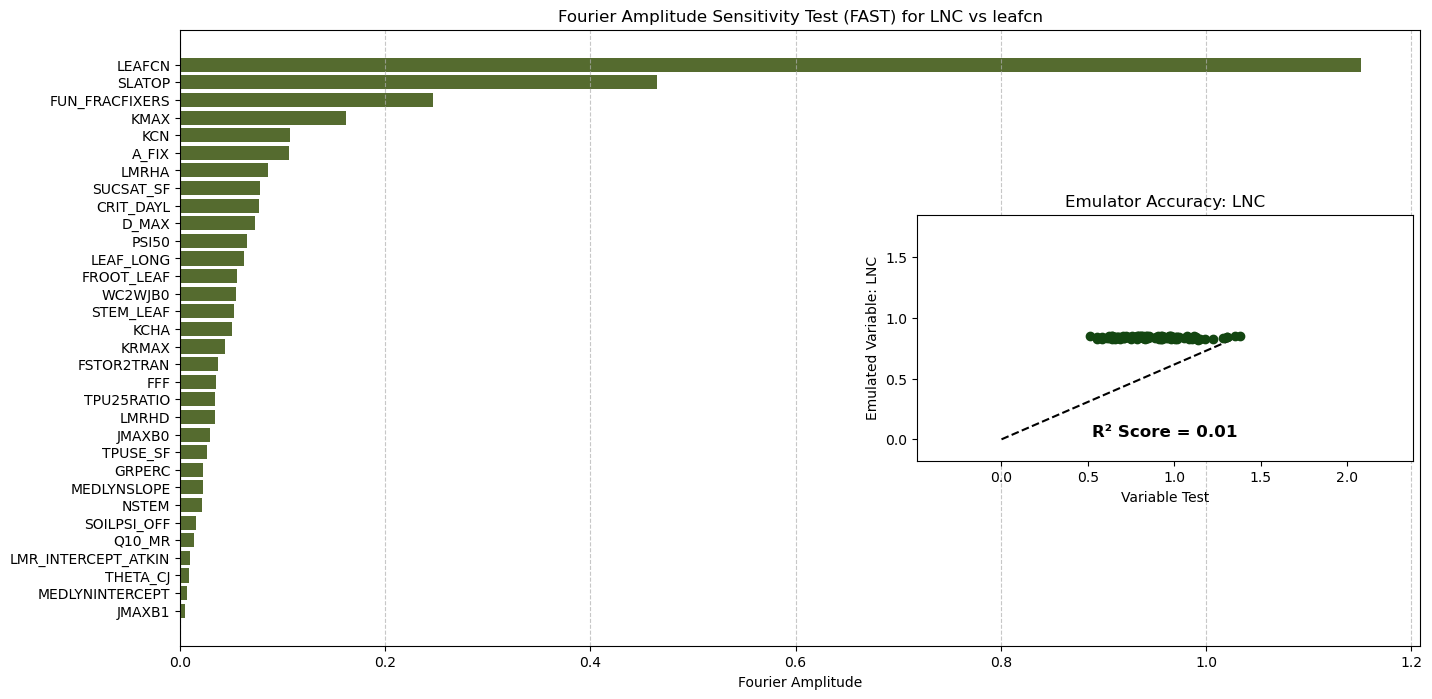

In [33]:
plot_FAST_accuracy(gpr_model, r2_emulator, y_test, y_pred, y_std)

In [ ]:
# integrating time into plotting
def plot_emulator2(var_name, param_name, param_names_dict, time_selection):
    # Load the pickled prediction data for the selected parameter 
    filename = os.path.join("emulation_results", f"{var_name}_{param_names_dict[param_name.upper()]}_{time_selection}_gpr_model.sav")
   
    with open(filename, 'rb') as file:
        X_values, y_pred, y_std, r2_emulator = pickle.load(file)

    # Get the parameter name corresponding to the index
    indexed_param = param_names_dict[param_name.upper()]

    # Calculate the z-score for the 99.7% confidence interval
    z_score = norm.ppf(0.99865)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(X_values[:, indexed_param],
             y_pred,
             color='#134611',
             label='GPR Prediction')

    plt.text(0.5, np.max(y_pred),
             f'R² Score = {r2_emulator:.2f}',
             fontsize=10)

    # Apply z-score for 99.7% CI
    plt.fill_between(X_values[:, indexed_param],
                     y_pred - z_score * y_std, y_pred + z_score * y_std,
                     alpha=0.5,
                     color='#9d6b53',
                     label='3 St.Dev., Confidence Interval')

    plt.xlabel(f'Perturbed Parameter: {param_name.title()}')
    plt.ylabel(f'Variable: {var_name.split("_")[0].title()}')
    plt.title('Parameter Perturbation Uncertainty Estimation')
    plt.legend()

    # Save the plot as a PNG file
    plt.savefig(f'plots/emulator/emulator_plot_{var_name}_{param_names_dict[param_name.upper()]}_{time_selection}_gpr_model.png')

    plt.show()